In [84]:
import csv
import numpy as np
import utils
import hrr_utils
import time
import random

from scipy import spatial
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

N=1000

def genX(verbs, indices):
    X = np.zeros((len(verbs), N)) # Exclusively difference PAST1-PRES1
    PRES1 = np.zeros((len(verbs), N))
    PRES2 = np.zeros((len(verbs), N))
    PAST1 = np.zeros((len(verbs), N))
    PAST2 = np.zeros((len(verbs), N))
    
    for m in range(len(indices)):
        pair = verbs[indices[m]]
        past1 = hrr_utils.GetRVClipHash(pair[1], dic1, 3)
        past2 = hrr_utils.GetRVClipHash(pair[1], dic2, 3)
        pres1 = hrr_utils.GetRVClipHash(pair[0], dic1, 3)
        pres2 = hrr_utils.GetRVClipHash(pair[0], dic2, 3)
        PRES1[m] = pres1
        PRES2[m] = pres2
        PAST1[m] = past1
        PAST2[m] = past2

    #X = np.where(PAST1-PRES1 > 0, 1, -1)
    X = PAST1-PRES1
    return X, PRES1, PRES2, PAST1, PAST2


def closed_train(Past, Present, rcond=5e-2):
    return np.dot(np.linalg.pinv(Present,rcond=rcond), Past)

# HD Algo
def train(W, past, present):
    # col x row
    W += np.outer(present, past)
    return W

def train_diff(W, past2, present1, present2):
    W += np.outer(present1, past2-present2)
    return W

def sim(x, y):
    if len(x.shape) == 1 or len(y.shape)==1:
        return np.dot(x, y)
    return np.sum(np.multiply(x, y), axis=1)

def nsim(x, y):
    x[x > 0] = 1
    x[x < 0] = -1
    y[y > 0] = 1
    y[y < 0] = -1
    
    return sim(x, y)

def round_to_tick(number):
    """Round a number to the closest half integer."""
    return round(number * 2) / 2

def graph(x, y1, y2, y1std, y2std, title=None, xlabel='number of words', ylabel='average dot product', legend='upper left'):   
    fig = plt.figure(figsize=(4,3))
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xticks(np.arange(0, 1701, 400))
    
    start = round_to_tick(min(min(y1), min(y2)) - max(max(y1std),max(y2std)))
    end = round_to_tick(max(max(y1), max(y2)) + max(max(y1std),max(y2std)))
    
    plt.yticks(np.arange(start-.5, end+.5, .5))
    plt.plot([0, 1700], [0, 0], 'k')

    plt.plot(x, y1, c='b', lw=2, label='Train')
    plt.plot(x, y2, c='g', lw=2, label='Test')

    plt.fill_between(x, y1-y1std, y1+y1std, facecolor='b', alpha=0.1)
    plt.fill_between(x, y2-y2std, y2+y2std, facecolor='g', alpha=0.1)

    plt.legend(loc=legend,fontsize=12)

    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Feature Similarity',fontsize=16)
    #plt.title(title,fontsize=16)

    plt.xlim([0, 1700])

    plt.tight_layout()
# https://matplotlib.org/api/lines_api.html
def graph_separate(x, y1, y2, y1std, y2std, \
                   y1irregular, y2irregular, \
                   title=None, xlabel='number of words', ylabel='average dot product', legend='upper left'):   

    fig = plt.figure(figsize=(4,3))
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.tick_params(axis='both', which='minor', labelsize=12)
    plt.xticks(np.arange(0, 1701, 400))
    start = round_to_tick(min(min(y1), min(y2)) - max(max(y1std),max(y2std)))
    end = round_to_tick(max(max(y1), max(y2)) + max(max(y1std),max(y2std)))
    
    plt.yticks(np.arange(start-.5, end+.5, .5))
    plt.plot([0, 1700], [0, 0], 'k')

    plt.plot(x, y1, c='b', lw=2, label='Train')
    plt.plot(x, y2, c='g', lw=2, label='Test')
    plt.plot(x, y1irregular, ':', c='b', lw=2, label='Train')
    plt.plot(x, y2irregular, ':', c='g', lw=2, label='Test')

    plt.fill_between(x, y1-y1std, y1+y1std, facecolor='b', alpha=0.1)
    plt.fill_between(x, y2-y2std, y2+y2std, facecolor='g', alpha=0.1)

    plt.legend(loc=legend,fontsize=12)

    plt.xlabel('Number Training Examples',fontsize=16)
    plt.ylabel('Feature Similarity',fontsize=16)
    plt.title(title,fontsize=16)

    plt.xlim([0, 1700])

    plt.tight_layout()

In [85]:
reg_pres, reg_past, reg_freq = utils.GetRegularVerbs(frequency=1)
irreg_pres, irreg_past, irreg_freq = utils.GetIrregularVerbs(frequency=1)


regular = zip(reg_pres, reg_past, reg_freq)
irregular = zip(irreg_pres, irreg_past, irreg_freq)

train_frac = 2/3.0

irregular_train_idx = int(train_frac*len(irreg_pres))
train_irreg = irregular[0:irregular_train_idx]

regular_train_idx = 1700 - len(train_irreg) 
train_reg = regular[0:regular_train_idx]

test_reg = regular[regular_train_idx:]
test_irreg = irregular[irregular_train_idx:]

dic1 = hrr_utils.GenerateDefaultDictionary(N)
dic2 = hrr_utils.GenerateDefaultDictionary(N)

train_all = train_reg + train_irreg
test_all = test_reg + test_irreg

train_all_indices = [i for i in range(len(train_all))]
test_all_indices = [i for i in range(len(test_all))]
random.shuffle(train_all_indices)
random.shuffle(test_all_indices)

In [86]:
trainX, trainpres1, trainpres2, trainpast1, trainpast2 = genX(train_all,train_all_indices)
testX, testpres1, testpres2, testpast1, testpast2 = genX(test_all, test_all_indices)

In [87]:
x = np.arange(1, trainpres1.shape[0], 10)
print x

[   1   11   21   31   41   51   61   71   81   91  101  111  121  131  141
  151  161  171  181  191  201  211  221  231  241  251  261  271  281  291
  301  311  321  331  341  351  361  371  381  391  401  411  421  431  441
  451  461  471  481  491  501  511  521  531  541  551  561  571  581  591
  601  611  621  631  641  651  661  671  681  691  701  711  721  731  741
  751  761  771  781  791  801  811  821  831  841  851  861  871  881  891
  901  911  921  931  941  951  961  971  981  991 1001 1011 1021 1031 1041
 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191
 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341
 1351 1361 1371 1381 1391 1401 1411 1421 1431 1441 1451 1461 1471 1481 1491
 1501 1511 1521 1531 1541 1551 1561 1571 1581 1591 1601 1611 1621 1631 1641
 1651 1661 1671 1681 1691]


In [90]:
x = np.arange(1, trainpres1.shape[0], 10)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])

ny1 = np.zeros(x.shape[0])
ny2 = np.zeros(x.shape[0])
ny1std = np.zeros(x.shape[0])
ny2std = np.zeros(x.shape[0])


y1irregular = np.zeros(x.shape[0])
y2irregular = np.zeros(x.shape[0])

sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]

rcond = 1e-15
#rcond = 5e-2

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    print k,
    W = closed_train(trainpast2[:k], trainpres1[:k], rcond)
    train_pred = trainpres1[:k].dot(W)
    test_pred = testpres1.dot(W)

    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    nsim1 = nsim(train_pred, trainpast2[:k])
    nsim2 = nsim(test_pred, testpast2)
    
    
    sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    y1[i] = sim1.mean()/N
    y1std[i] = np.nanstd(sim1, axis=0)/N
    y2[i] = sim2.mean()/N
    y2std[i] = np.nanstd(sim2, axis=0)/N
    
    ny1[i] = nsim1.mean()/N
    ny1std[i] = np.nanstd(nsim1, axis=0)/N
    ny2[i] = nsim2.mean()/N
    ny2std[i] = np.nanstd(nsim2, axis=0)/N
    
    
    y1irregular[i] = irregularsim1.mean()/N
    y2irregular[i] = irregularsim2.mean()/N
    

 1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341 1351 1361 1371 1381 1391 1401 1411 1421 1431 1441 1451 1461 1471 1481 1491 1501 1511 1521 1531 1541 1551 1561 1571 1581 1591 1601 1611 1621 1631 1641 1651 1661 1671 1681 1691


In [94]:
fname = ("data/regression_similarity-nsim-N=" + str(N) + '-W=' + str(len(trainpres1)) + '-rc=' + str(rcond)
        + '-' + time.strftime('%y%m%d'))

print fname

np.savez(fname + '.npz', train_mean=y1, train_std=y1std, test_mean=y2, test_std=y2std,
        ntrain_mean=ny1, ntrain_std=ny1std, ntest_mean=ny2, ntest_std=ny2std)

data/regression_similarity-nsim-N=1000-W=1700-rc=1e-15-170517


figures/regression-N=1000-W=1700-rc=1e-15-170517


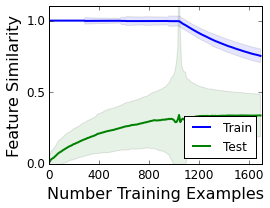

In [92]:
graph(x,y1,y2,y1std,y2std,title="unregularized", legend="lower right")

plt.ylim([0, 1.1])

fname =  ('figures/regression-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-rc=' + str(rcond)
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/regression-nsim-N=1000-W=1700-rc=1e-15-170517


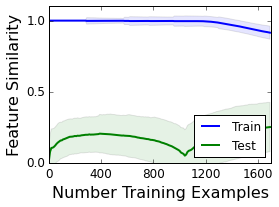

In [93]:
graph(x,ny1,ny2,ny1std,ny2std,title="unregularized", legend="lower right")

plt.ylim([0, 1.1])

fname =  ('figures/regression-nsim-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-rc=' + str(rcond)
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [95]:
x = np.arange(1, trainpres1.shape[0], 10)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])


ny1 = np.zeros(x.shape[0])
ny2 = np.zeros(x.shape[0])
ny1std = np.zeros(x.shape[0])
ny2std = np.zeros(x.shape[0])


y1irregular = np.zeros(x.shape[0])
y2irregular = np.zeros(x.shape[0])

sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]
#rcond = 1e-15
rcond = 5e-2

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    print k,
    W = closed_train(trainpast2[:k]-trainpres2[:k], trainpres1[:k])
    train_pred = trainpres1[:k].dot(W) + trainpres2[:k]
    test_pred = testpres1.dot(W) + testpres2

    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    nsim1 = nsim(train_pred, trainpast2[:k])
    nsim2 = nsim(test_pred, testpast2)
    
    
    sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    y1[i] = sim1.mean()/N
    y1std[i] = np.nanstd(sim1, axis=0)/N
    y2[i] = sim2.mean()/N
    y2std[i] = np.nanstd(sim2, axis=0)/N
    
    ny1[i] = nsim1.mean()/N
    ny1std[i] = np.nanstd(nsim1, axis=0)/N
    ny2[i] = nsim2.mean()/N
    ny2std[i] = np.nanstd(nsim2, axis=0)/N
    
    
    
    y1irregular[i] = irregularsim1.mean()/N
    y2irregular[i] = irregularsim2.mean()/N
   

1 11 21 31 41 51 61 71 81 91 101 111 121 131 141 151 161 171 181 191 201 211 221 231 241 251 261 271 281 291 301 311 321 331 341 351 361 371 381 391 401 411 421 431 441 451 461 471 481 491 501 511 521 531 541 551 561 571 581 591 601 611 621 631 641 651 661 671 681 691 701 711 721 731 741 751 761 771 781 791 801 811 821 831 841 851 861 871 881 891 901 911 921 931 941 951 961 971 981 991 1001 1011 1021 1031 1041 1051 1061 1071 1081 1091 1101 1111 1121 1131 1141 1151 1161 1171 1181 1191 1201 1211 1221 1231 1241 1251 1261 1271 1281 1291 1301 1311 1321 1331 1341 1351 1361 1371 1381 1391 1401 1411 1421 1431 1441 1451 1461 1471 1481 1491 1501 1511 1521 1531 1541 1551 1561 1571 1581 1591 1601 1611 1621 1631 1641 1651 1661 1671 1681 1691


In [96]:
fname = ("data/regression_diff_similarity-nsim-N=" + str(N) + '-W=' + str(len(trainpres1)) + '-rc=' + str(rcond)
        + '-' + time.strftime('%y%m%d'))

print fname

np.savez(fname + '.npz', train_mean=y1, train_std=y1std, test_mean=y2, test_std=y2std, 
        ntrain_mean=ny1, ntrain_std=ny1std, ntest_mean=ny2, ntest_std=ny2std)

data/regression_diff_similarity-nsim-N=1000-W=1700-rc=0.05-170517


figures/regression_diff-N=1000-W=1700-rc=0.05-170517


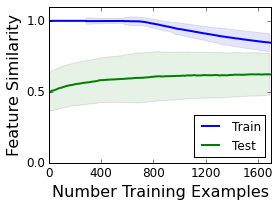

In [97]:
graph(x,y1,y2,y1std,y2std,title="unregularized", legend="lower right")

plt.ylim([0, 1.1])

fname =  ('figures/regression_diff-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-rc=' + str(rcond)
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/regression_diff-nsim-N=1000-W=1700-rc=0.05-170517


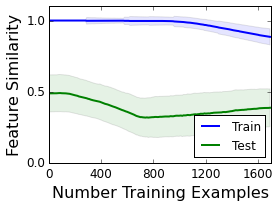

In [98]:
graph(x,ny1,ny2,ny1std,ny2std,title="unregularized", legend="lower right")

plt.ylim([0, 1.1])

fname =  ('figures/regression_diff-nsim-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-rc=' + str(rcond)
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [99]:
W = np.zeros((N,N))
W = train(W, trainpast2[0], trainpres1[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])

ny1 = np.zeros(x.shape[0])
ny2 = np.zeros(x.shape[0])
ny1std = np.zeros(x.shape[0])
ny2std = np.zeros(x.shape[0])


y1irregular = np.zeros(x.shape[0])
y2irregular = np.zeros(x.shape[0])

sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]

for i in range(x.shape[0]):
    k = x[i]
    train_pred = W.T.dot(trainpres1[:k].T).T / N
    test_pred = W.T.dot(testpres1.T).T / N

    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    nsim1 = nsim(train_pred, trainpast2[:k])
    nsim2 = nsim(test_pred, testpast2)
    
    sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    y1[i] = sim1.mean()/N
    y1std[i] = np.nanstd(sim1, axis=0)/N
    y2[i] = sim2.mean()/N
    y2std[i] = np.nanstd(sim2, axis=0)/N
    
    ny1[i] = nsim1.mean()/N
    ny1std[i] = np.nanstd(nsim1, axis=0)/N
    ny2[i] = nsim2.mean()/N
    ny2std[i] = np.nanstd(nsim2, axis=0)/N
    
    y1irregular[i] = irregularsim1.mean()/N
    y2irregular[i] = irregularsim2.mean()/N
    
    
    W = train(W, trainpast2[k], trainpres1[k])
    

In [104]:
fname = ("data/unreg_outer_similarity-nsim-N=" + str(N) + '-W=' + str(len(trainpres1)) + '-rc=' + str(rcond)
        + '-' + time.strftime('%y%m%d'))

print fname

np.savez(fname + '.npz', train_mean=y1, train_std=y1std, test_mean=y2, test_std=y2std,
        ntrain_mean=ny1, ntrain_std=ny1std, ntest_mean=ny2, ntest_std=ny2std)

data/unreg_outer_similarity-nsim-N=1000-W=1700-rc=0.05-170517


figures/unregularized_outer-N=1000-W=1700-170517


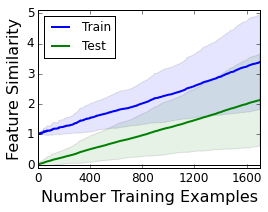

In [100]:
graph(x,y1,y2,y1std,y2std,title="unregularized", legend="upper left")

plt.ylim([-0.1, 5.1])
plt.yticks(np.arange(6))

fname =  ('figures/unregularized_outer-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/unregularized_outer-nsim-N=1000-W=1700-170517


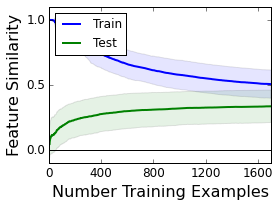

In [103]:
graph(x,ny1,ny2,ny1std,ny2std,title="unregularized", legend="upper left")

plt.ylim([-0.1, 1.1])

fname =  ('figures/unregularized_outer-nsim-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [105]:
def reg_train(W, Past, Present):
    pred = np.dot(W, Present)
    W += ((N*N-sim(pred, Past))/float(N*N)) * np.outer(Past, Present)
    return W

In [106]:
W = np.zeros((N,N))
W = reg_train(W, trainpast2[0], trainpres1[0])

x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])
ny1 = np.zeros(x.shape[0])
ny2 = np.zeros(x.shape[0])
ny1std = np.zeros(x.shape[0])
ny2std = np.zeros(x.shape[0])

y1irregular = np.zeros(x.shape[0])
y2irregular = np.zeros(x.shape[0])

sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]

for i in range(x.shape[0]):
    k = x[i]
    #print k,
    #train_pred = W.T.dot(trainpres1[:k].T).T
    #test_pred = W.T.dot(testpres1.T).T
    
    train_pred = np.dot(W, trainpres1[:k, :].T).T / N
    test_pred = np.dot(W, testpres1.T).T / N
    
    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    
    nsim1 = nsim(train_pred, trainpast2[:k])
    nsim2 = nsim(test_pred, testpast2)
    
    sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    y1[i] = sim1.mean()/N
    y1std[i] = np.nanstd(sim1, axis=0)/N
    y2[i] = sim2.mean()/N
    y2std[i] = np.nanstd(sim2, axis=0)/N
    ny1[i] = nsim1.mean()/N
    ny1std[i] = np.nanstd(nsim1, axis=0)/N
    ny2[i] = nsim2.mean()/N
    ny2std[i] = np.nanstd(nsim2, axis=0)/N
    
    y1irregular[i] = irregularsim1.mean()/N
    y2irregular[i] = irregularsim2.mean()/N
    
    W = reg_train(W, trainpast2[k], trainpres1[k])
   

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 

figures/regularized_outer-N=1000-W=1700-170517


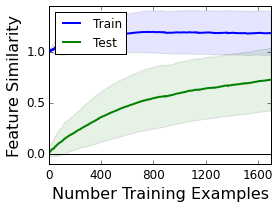

In [107]:
 
graph(x,y1,y2,y1std,y2std,title="regularized", legend="upper left")

plt.ylim([-0.1, 1.45])

fname =  ('figures/regularized_outer-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/regularized_outer-nsim-N=1000-W=1700-170517


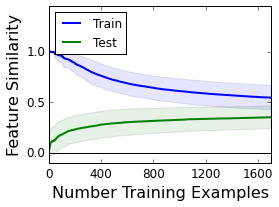

In [109]:
 
graph(x,ny1,ny2,ny1std,ny2std,title="regularized", legend="upper left")

plt.ylim([-0.1, 1.45])

fname =  ('figures/regularized_outer-nsim-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname
plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [108]:
fname = ("data/reg_outer_similarity-nsim-N=" + str(N) + '-W=' + str(len(trainpres1)) + '-rc=' + str(rcond)
        + '-' + time.strftime('%y%m%d'))

print fname

np.savez(fname + '.npz', train_mean=y1, train_std=y1std, test_mean=y2, test_std=y2std,
        ntrain_mean=ny1, ntrain_std=ny1std, ntest_mean=ny2, ntest_std=ny2std)

data/reg_outer_similarity-nsim-N=1000-W=1700-rc=0.05-170517


In [110]:
W = np.zeros((N,N))
W = train_diff(W, trainpast2[0], trainpres1[0], trainpres2[0])

x = np.arange(1, trainpres1.shape[0], 1)
y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])

y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])

ny1 = np.zeros(x.shape[0])
ny2 = np.zeros(x.shape[0])
ny1std = np.zeros(x.shape[0])
ny2std = np.zeros(x.shape[0])


y1irregular = np.zeros(x.shape[0])
y2irregular = np.zeros(x.shape[0])

sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    #train_pred = trainpres1[:k].dot(W)
    #train_pred = np.where(train_pred>0, 1, -1)
    #test_pred = testpres1.dot(W)
    #test_pred = np.where(test_pred>0, 1, -1)
    
    train_pred = W.T.dot(trainpres1[:k].T).T/N + trainpres2[:k]
    test_pred = W.T.dot(testpres1.T).T/N + (testpres2)
    
    #y1[i] = sim(train_pred/float(N), trainpast2[:k]).mean()
    #y2[i] = sim(test_pred/float(N), testpast2).mean()
    
    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    nsim1 = nsim(train_pred, trainpast2[:k])
    nsim2 = nsim(test_pred, testpast2)
    
    sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    y1[i] = sim1.mean()/N
    y1std[i] = np.nanstd(sim1, axis=0)/N
    y2[i] = sim2.mean()/N
    y2std[i] = np.nanstd(sim2, axis=0)/N
    ny1[i] = nsim1.mean()/N
    ny1std[i] = np.nanstd(nsim1, axis=0)/N
    ny2[i] = nsim2.mean()/N
    ny2std[i] = np.nanstd(nsim2, axis=0)/N
    
    
    y1irregular[i] = irregularsim1.mean()/N
    y2irregular[i] = irregularsim2.mean()/N
    
    W = train_diff(W, trainpast2[k], trainpres1[k], trainpres2[k])

figures/unregularized_outer_diff-N=1000-W=1700-170517


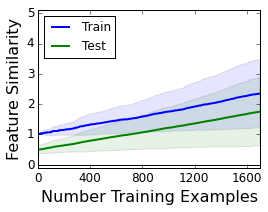

In [111]:
graph(x,y1,y2,y1std,y2std,title="diff-unregularized", legend="upper left")

plt.ylim([-0.1, 5.1])
plt.yticks(np.arange(6))

fname =  ('figures/unregularized_outer_diff-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/unregularized_outer_diff-nsim-N=1000-W=1700-170517


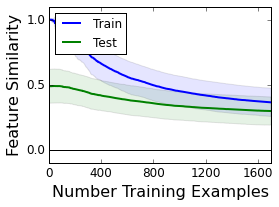

In [115]:
graph(x,ny1,ny2,ny1std,ny2std,title="diff-unregularized", legend="upper left")

plt.ylim([-0.1, 1.1])

fname =  ('figures/unregularized_outer_diff-nsim-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [113]:
fname = ("data/unreg_outer_diff_similarity-nsim-N=" + str(N) + '-W=' + str(len(trainpres1)) + '-rc=' + str(rcond)
        + '-' + time.strftime('%y%m%d'))

print fname

np.savez(fname + '.npz', train_mean=y1, train_std=y1std, test_mean=y2, test_std=y2std,
        ntrain_mean=ny1, ntrain_std=ny1std, ntest_mean=ny2, ntest_std=ny2std)

data/unreg_outer_diff_similarity-nsim-N=1000-W=1700-rc=0.05-170517


In [116]:
def reg_train_diff(W, past2, present1, present2):
    pred = np.dot(W, present1)/N + present2
    W += ((N-sim(pred, past2))/float(N)) * np.outer(present1, past2-present2)
    return W

In [121]:
W = np.zeros((N,N))
W = reg_train_diff(W, trainpast2[0], trainpres1[0], trainpres2[0])
random_vecs = np.random.randn(testpast2.shape[0], N)
x = np.arange(1, trainpres1.shape[0], 1)

y1 = np.zeros(x.shape[0])
y2 = np.zeros(x.shape[0])
y1std = np.zeros(x.shape[0])
y2std = np.zeros(x.shape[0])

ny1 = np.zeros(x.shape[0])
ny2 = np.zeros(x.shape[0])
ny1std = np.zeros(x.shape[0])
ny2std = np.zeros(x.shape[0])


y1irregular = np.zeros(x.shape[0])
y2irregular = np.zeros(x.shape[0])

sim2indices = [j for j in range(testpres1.shape[0]) if test_all_indices[j] >= len(test_reg)]

for i in range(x.shape[0]):#trainpres1.shape[0]):
    k = x[i]
    
    #print k,

    train_pred = W.T.dot(trainpres1[:k].T).T/N + trainpres2[:k]
    test_pred = W.T.dot(testpres1.T).T/N + (testpres2)
    
    #print (train_pred.shape, test_pred.shape)
#     y1[i] = sim(train_pred/float(N), trainpast2[:k]).mean()
#     y2[i] = sim(test_pred/float(N), testpast2).mean()
    
    sim1 = sim(train_pred, trainpast2[:k])
    sim2 = sim(test_pred, testpast2)
    nsim1 = nsim(train_pred, trainpast2[:k])
    nsim2 = nsim(test_pred, testpast2)
    
    sim1indices = [j for j in range(sim1.shape[0]) if train_all_indices[j] >= len(train_reg)]

    irregularsim1 = sim1[sim1indices]
    irregularsim2 = sim2[sim2indices]
    
    y1[i] = sim1.mean()/N
    y1std[i] = np.nanstd(sim1, axis=0)/N
    y2[i] = sim2.mean()/N
    y2std[i] = np.nanstd(sim2, axis=0)/N
    ny1[i] = nsim1.mean()/N
    ny1std[i] = np.nanstd(nsim1, axis=0)/N
    ny2[i] = nsim2.mean()/N
    ny2std[i] = np.nanstd(nsim2, axis=0)/N
    
    y1irregular[i] = irregularsim1.mean()/N
    y2irregular[i] = irregularsim2.mean()/N
      
    W = reg_train_diff(W, trainpast2[k], trainpres1[k], trainpres2[k])

figures/regularized_outer_diff-N=1000-W=1700-170517


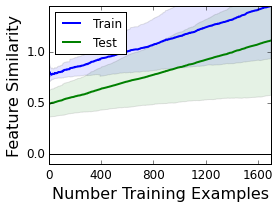

In [122]:
graph(x,y1,y2,y1std,y2std,title='diff-regularized', legend='upper left')
plt.ylim([-0.1, 1.45])

fname =  ('figures/regularized_outer_diff-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

figures/regularized_outer_diff-nsim-N=1000-W=1700-170517


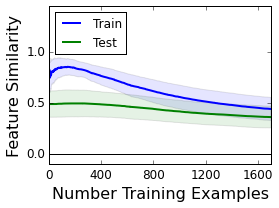

In [123]:
graph(x,ny1,ny2,ny1std,ny2std,title='diff-regularized', legend='upper left')
plt.ylim([-0.1, 1.45])

fname =  ('figures/regularized_outer_diff-nsim-N=' + str(N) + '-W=' + str(len(trainpres1)) 
          + '-' + time.strftime('%y%m%d'))
print fname

plt.savefig(fname + '.png', transparent=True)
plt.savefig(fname + '.eps', transparent=True)

In [124]:
fname = ("data/reg_outer_diff_similarity-nsim-N=" + str(N) + '-W=' + str(len(trainpres1)) + '-rc=' + str(rcond)
        + '-' + time.strftime('%y%m%d'))

print fname

np.savez(fname + '.npz', train_mean=y1, train_std=y1std, test_mean=y2, test_std=y2std,
         ntrain_mean=ny1, ntrain_std=ny1std, ntest_mean=ny2, ntest_std=ny2std)

data/reg_outer_diff_similarity-nsim-N=1000-W=1700-rc=0.05-170517
